In [2]:
import warnings
from pathlib import Path
import json
import re
from multiprocessing import Pool

import numpy as np  
from scipy.optimize import minimize, OptimizeWarning, show_options

import emcee
from emcee.autocorr import AutocorrError
import corner

# Support for interactive widgets
from IPython.display import *
from ipywidgets import Dropdown

# %matplotlib widget 
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", "Using UFloat objects with std_dev==0 may give unexpected results.", category=UserWarning)
from uncertainties import ufloat
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
from astroquery.gaia import Gaia

from dust_extinction.parameter_averages import F99, F04, G23

from deblib.constants import M_sun, R_sun
from deblib.stellar import log_g

from libs import extinction
from libs.pipeline import get_teff_from_spt
from libs.sed import get_sed_for_target, create_outliers_mask, group_and_average_fluxes
from libs.sed import calculate_vfv
from libs.pyssed import ModelSed
from libs.fit_sed import create_prior_criteria, create_theta, model_func, minimize_fit, mcmc_fit
from libs.plots import plot_sed

/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


### Load the PySSED bt-settle model and set up the related model functions 

__Note:__ The data file is currently a copy of that kindly published on [GitHub](https://github.com/iain-mcdonald/PySSED)
by [McDonald at al., (2024)](https://ui.adsabs.harvard.edu/abs/2024RASTI...3...89M/abstract)

First we load the pre-built data of bt-settle synthetic SED which have previously been parsed
and saved with the `makemodel.py` module. The data file contains fluxes over a range of filters
for combinations of $T_{\rm eff}$, $\log{g}$, $[{\rm Fe/H}]$ and $[{\rm \alpha/Fe}]$. We build a
table in memory which holds a `RegularGridInterpolator` for each filter, with the dimensions/axes
being the $T_{\rm eff}$ and $\log{g}$ values and the values being the corresponding fluxes.

For now we consider only the data for solar metallicity, hence the interpolators only cover
$[{\rm Fe/H}] = 0$ and $[{\rm \alpha/Fe}] = 0$, however additional axes/dimensions
for $[{\rm Fe/H}]$ and $[{\rm \alpha/Fe}]$ may be added, if required.

In [3]:
# Read the pre-built bt-settl model file
model_sed = ModelSed("libs/data/pyssed/model-bt-settl-recast.dat")

print(f"Loaded previously built dataset of solar metallicity pyssed spectra covering the ranges:")
print(f"wavelength {model_sed.wavelength_range:unicode}, Teff {model_sed.teff_range:unicode}",
      f"and logg {model_sed.logg_range:unicode}")

Loaded previously built dataset of solar metallicity pyssed spectra covering the ranges:
wavelength [ 0.3 22. ] µm, Teff [ 1900. 70000.] K and logg [-0.5  6. ] dex


### Set up the extinction model

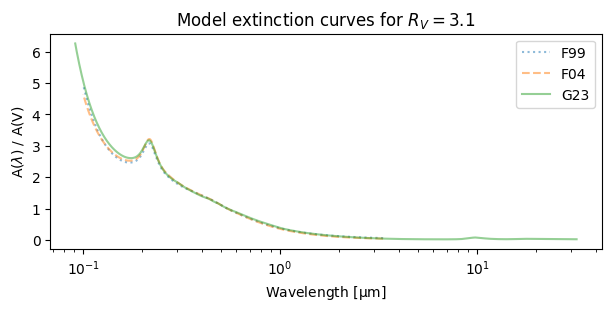

Using the G23 extinction model covers the range from 0.0912 µm to 32.0 µm.


In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), constrained_layout=True)
for (_mod, _ls) in [(F99, ":"), (F04, "--"), (G23, "-")]:
    _lambda = (1 / np.logspace(*np.log10(_mod.x_range), num=1000)) * u.um
    ax.plot(_lambda, _mod(Rv=3.1)(_lambda), ls=_ls, alpha=0.5, label=f"{_mod.name}")
ax.set(title=f"Model extinction curves for $R_V=3.1$", xscale="log",
       xlabel=f"Wavelength [{_lambda.unit:latex_inline}]", ylabel=r"A($\lambda$) / A(V)")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

# The G23 (Gordon et al., 2023) Milky Way R(V) filter gives us the broadest coverage
ext_model = G23(Rv=3.1)
ext_wl_range = np.reciprocal(ext_model.x_range) * u.um # x_range has implicit units of 1/micron
print(f"Using the {ext_model.__class__.__name__} extinction model covers the range from",
      f"{min(ext_wl_range):unicode} to {max(ext_wl_range):unicode}.")

### Select our target and get its known information

In [5]:
default_target = "CM Dra"
targets_config_file = Path.cwd() / "config" / "fitting-a-sed-targets.json"
with open(targets_config_file, mode="r", encoding="utf8") as f:
    full_dict = json.load(f)
targets_cfg = { k: full_dict[k] for k in full_dict if full_dict[k].get("enabled", True) }

max_teff = max(model_sed.teff_range).to(u.K).value
options = [
    (f"{t}" + (" *" if c.get("exclude", False) else "") + (" [too hot!]" if min(c["TeffA"], c["TeffB"]) > max_teff else ""), t)
        for t, c in targets_cfg.items()
]

target_selection = Dropdown(options=options, value=default_target, description="Targets:")
display(target_selection)

Dropdown(description='Targets:', index=31, options=(('V436 Per', 'V436 Per'), ('V539 Ara', 'V539 Ara'), ('MU C…

In [6]:
target = target_selection.value
target_config = targets_cfg[target]
target_config.setdefault("loggA", log_g(target_config["MA"] * M_sun, target_config["RA"] * R_sun).n)
target_config.setdefault("loggB", log_g(target_config["MB"] * M_sun, target_config["RB"] * R_sun).n)

# Additional data on the target populated with lookups
target_data = {
    "label": target_config.get("label", target),
    "search_term": target_config.get("search_term", target)
}

_simbad = Simbad()
_simbad.add_votable_fields("sp", "ids")
if _tbl := _simbad.query_object(target_data["search_term"]):
    target_data["ids"] = np.array(re.findall(r"(Gaia DR3|V\*|TIC|HD|HIP|2MASS)\s+(.+?(?=\||$))", _tbl["ids"][0]),
                                    dtype=[("type", object), ("id", object)])
    print(f"IDs:", ", ".join(f"{i['type']} {i['id']}" for i in target_data["ids"]))
    target_data["spt"] = _tbl["sp_type"][0]
    print(f"SpT:", target_data["spt"])

IDs: Gaia DR3 1431176943768690816, 2MASS J16342040+5709439, V* CM Dra, 2MASS J16342041+5709489, TIC 199574208, TIC 199574209
SpT: M4.5V


In [7]:
# Let's get the Gaia DR3 data on this here object
_gaia_dr3_id = target_data["ids"][target_data["ids"]["type"] == "Gaia DR3"]["id"][0]
if _job := Gaia.launch_job(f"SELECT TOP 1 * FROM gaiadr3.gaia_source WHERE source_id = {_gaia_dr3_id}"):
    _tbl = _job.get_results()
    target_data["parallax_mas"] = ufloat(_tbl["parallax"][0], _tbl["parallax_error"][0])
    target_data["skycoords"] = _coords = SkyCoord(ra=_tbl["ra"][0] * u.deg, dec=_tbl["dec"][0] * u.deg,
                                                  distance=1000 / _tbl["parallax"][0] * u.pc, frame="icrs")
    print(f"{target} SkyCoords are {_coords} (or {_coords.to_string('hmsdms')})")
    target_data["bp_rp"] = _tbl["bp_rp"][0]
    target_data["phot_g_mean_mag"] = _tbl["phot_g_mean_mag"][0]
    target_data["ruwe"] = _tbl["ruwe"][0]

CM Dra SkyCoords are <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (248.57558061, 57.16757382, 14.86158398)> (or 16h34m18.13934594s +57d10m03.26574348s)


In [8]:
# Lookup the TESS Input Catalog (8.2) for starting "system" Teff and logg values
target_data["teff_sys"] = get_teff_from_spt(target_data["spt"]) or ufloat(5700, 0)
target_data["logg_sys"] = ufloat(4.0, 0)
if _tbl := Vizier(catalog="IV/39/tic82").query_object(target_data["search_term"], radius=0.1 * u.arcsec):
    if _row := _tbl[0][_tbl[0]["TIC"] in target_data["ids"][target_data["ids"]["type"] == "TIC"]["id"]]:
        # Teff may not be reliable - only use it if it's consistent with the SpT
        if target_data["teff_sys"].n-target_data["teff_sys"].s < (_row["Teff"] or 0) < target_data["teff_sys"].n+target_data["teff_sys"].s:
            target_data["teff_sys"] = ufloat(_row["Teff"], _row.get("s_Teff", None) or 0)
        if (_row["logg"] or 0) > 0:
            target_data["logg_sys"] = ufloat(_row["logg"], _row.get("s_logg", None) or 0)

# Other priors will likely come out of light curve fitting with JKTEBOP - get from config for now
target_data["k"] = ufloat(target_config.get("k"), target_config.get("k_err", 0) or 0)
if "light_ratio" in target_config:
    target_data["light_ratio"] = ufloat(target_config.get("light_ratio"), target_config.get("light_ratio_err", 0) or 0)
else:
    # If from LC fit we may also need to consider l3; lA=(1-l3)/(1+(LB/LA)) & lB=(1-l3)/(1+1/(LB/LA))
    target_data["light_ratio"] = ufloat(10**(target_config.get("logLB", 1) - target_config.get("logLA", 1)), 0)
target_data["teff_ratio"] = (target_data["light_ratio"] / target_data["k"]**2)**0.25

# Estimate the teffs, based on the published system value and the ratio from fitting
if target_data["teff_ratio"].n <= 1:
    target_data["teffs0"] = [target_data["teff_sys"].n, (target_data["teff_sys"] * target_data["teff_ratio"]).n]
else:
    target_data["teffs0"]  = [(target_data["teff_sys"] / target_data["teff_ratio"]).n, target_data["teff_sys"].n]

print(f"{target} system values from lookup and LC fitting:")
for p, unit in [("teff_sys", u.K), ("logg_sys", u.dex), ("k", None), ("light_ratio", None), ("teff_ratio", None)]:
    print(f"{p:>12s} = {target_data[p]:.3f} {unit or u.dimensionless_unscaled:unicode}")
print(f"      teffs0 = [{', '.join(f'{t:.3f}' for t in target_data['teffs0'])}]")

CM Dra system values from lookup and LC fitting:
    teff_sys = 3214.000+/-157.000 K
    logg_sys = 4.906+/-0.004 dex
           k = 0.945+/-0.001 
 light_ratio = 0.881+/-0 
  teff_ratio = 0.997+/-0.000 
      teffs0 = [3214.000, 3203.170]


### Get the SED data for the target
- apply default uncertainties to those measurements with none
- remove duplicate SED measurements
- group and average SED measurements by filter & frequency
- exclude measurements outside the range of our extinction model
- optionally exclude flux outliers

In [9]:
# Read in the SED for this target and de-duplicate (measurements may appear multiple times).
# Work in Jy rather than W/m^2/Hz as they are a more natural unit, giving values that minimize 
# potential FP rounding. Plots are agnostic and plot wl [um] and vF(v) [W/m^2] on x and y.
sed = get_sed_for_target(target, target_data["search_term"], radius=0.1, remove_duplicates=True,
                         freq_unit=u.GHz, flux_unit=u.Jy, wl_unit=u.um, verbose=True)

sed = group_and_average_fluxes(sed, verbose=True)

# Filter SED to those covered by our models and also remove any outliers
model_mask = np.ones((len(sed)), dtype=bool)
model_mask &= np.array([model_sed.has_filter(f) for f in sed["sed_filter"]])
model_mask &= (sed["sed_wl"] >= min(ext_wl_range)) \
            & (sed["sed_wl"] <= max(ext_wl_range)) \
            & (sed["sed_wl"] >= min(model_sed.wavelength_range)) \
            & (sed["sed_wl"] <= max(model_sed.wavelength_range))
sed = sed[model_mask]

out_mask = create_outliers_mask(sed, target_data["teffs0"], min_unmasked=15, verbose=True)
sed = sed[~out_mask]

sed.sort(["sed_wl"])
print(f"{len(sed)} unique SED observation(s) retained after range and outlier filtering",
      "\nwith the units for flux, frequency and wavelength being",
      ", ".join(f"{sed[f].unit:unicode}" for f in ["sed_flux", "sed_freq", "sed_wl"]))

Opened SED table cm-dra-0.1.vot containing 28 row(s).
Dropped 10 duplicate(s) leaving 18 unique row(s).
Grouped SED by ['sed_filter', 'sed_freq'] yielding 12 group(s) from 18 row(s).
Calculating the group means of the [('sed_flux', 'sed_eflux')] columns
No outliers masked as already 15 or fewer SED rows
11 unique SED observation(s) retained after range and outlier filtering 
with the units for flux, frequency and wavelength being Jy, GHz, µm


### De-redden the SED
Use the target coordinates to find an $E(B-V)$ value from the available extinction maps.
With this we can deredden the remaining SED fluxes using the previously created extinction model. 

In [10]:
for val, flags in extinction.get_ebv(target_data["skycoords"], rv=ext_model.Rv):
    if val and not np.isnan(val) and flags.get("converged", False):
        print(f"Found extinction with {flags['source']}: E(B-V) = {val:.6f}")
        sed["sed_der_flux"] = sed["sed_flux"] / ext_model.extinguish(sed["sed_wl"].to(u.um), Ebv=val)
        break

if "sed_der_flux" in sed.colnames:
    der_lab = "dereddened"
else:
    sed["sed_der_flux"] = sed["sed_flux"]
    der_lab = "not dereddened"

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 25.316 s
  pix_info:   0.341 s
   samples:  14.149 s
      best:   2.842 s
       nan:   0.021 s
      sort:   7.876 s
       idx:   0.087 s
Querying Galactic interstellar dust Gaia-2MASS 3D maps (2022A&A...664A.174V) for extinction data.
Found extinction with get_vergely_av: E(B-V) = 0.000515


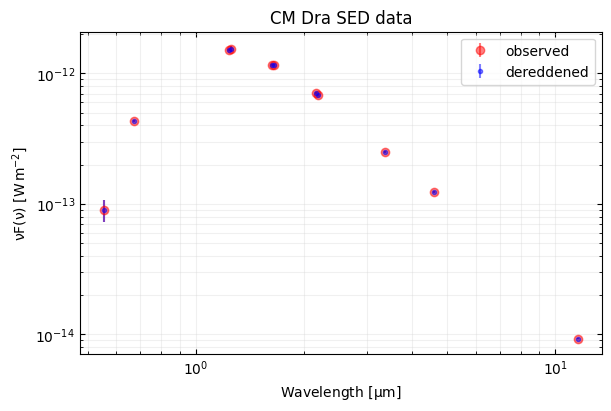

In [11]:
fig = plot_sed(sed["sed_wl"].quantity,
               fluxes=[sed["sed_flux"].quantity, sed["sed_der_flux"].quantity],
               flux_errs=[sed["sed_eflux"].quantity]*2,
               fmts=["or", ".b"],
               labels=["observed", der_lab],
               title=target_data['label'] + " SED data")
plt.show(fig)
plt.close(fig)

### Set up the functions which will support fitting

This is a function which plots the fitted vs observed SED data.

In [12]:
def plot_fitted_model(sed, theta, title):
    # Generate model SED fluxes at points x for each set of component star params in theta
    x = model_sed.get_filter_indices(sed["sed_filter"])
    comp_fluxes = model_func(theta, x, model_sed.get_fluxes, combine=False) * u.Jy
    sys_flux = np.sum(comp_fluxes, axis=0)

    # Plot the fitted model against the derredened SED + show each star's contribution
    fig = plot_sed(x=sed["sed_wl"].to(u.um),
                   fluxes=[sed["sed_der_flux"].quantity, sys_flux, comp_fluxes[0], comp_fluxes[1]],
                   flux_errs=[sed["sed_eflux"].quantity, None, None, None],
                   fmts=["ob", ".k", "*g", "xr"],
                   labels=["dereddened SED", "fitted pair", "fitted star A", "fitted star B"],
                   title=title)
    plt.show(fig)
    plt.close(fig)

We set the starting position for the fit, `theta0`, which is our best estimate of the
fitted values for the system based on existing published data and any light-curve fitting carried
out previously.

The `fit_mask` indicates which of the values in `theta0` is fitted, with the remainder being fixed.

**Note:** currently we're not fitting for $\log{g}$, instead using fixed values for each star.

In [13]:
theta_plot_labels = np.array([r"$T_{\rm eff,A} / {\rm K}$", r"$T_{\rm eff,B} / {\rm K}$",
                              r"$R_{\rm A} / {\rm R_{\odot}}$", r"$R_{\rm B} / {\rm R_{\odot}}$",
                              r"$\log{g}_{\rm A}$", r"$\log{g}_{\rm B}$",
                              r"${\rm distance} / {\rm m}$"])
theta_labels = np.array([("TeffA", u.K), ("TeffB", u.K), ("RA", u.Rsun), ("RB", u.Rsun),
                         ("loggA", u.dex), ("loggB", u.dex), ("dist", u.pc)])

NUM_STARS = 2
theta0 = create_theta(
    teffs=target_data["teffs0"].copy(),
    radii=[1.0] * NUM_STARS,
    loggs=[target_data["logg_sys"].n] * NUM_STARS,
    dist=target_data["skycoords"].distance.to(u.pc).value,
    nstars=NUM_STARS,
    verbose=True
)

fit_mask = np.array([True] * NUM_STARS      # teff
                  + [True] * NUM_STARS      # radius
                  + [False] * NUM_STARS     # logg
                  + [False])                # dist

print(f"For {target} we set the starting position (theta0) to be:",
    *(f"\n{l:>9s} = {theta0[ix]:.3f} {unit:unicode}" for ix, (l, unit) in enumerate(theta_labels)))

theta:	 3.214e+03, 3.203e+03, 1.000e+00, 1.000e+00, 4.906e+00, 4.906e+00, 1.486e+01
For CM Dra we set the starting position (theta0) to be: 
    TeffA = 3214.000 K 
    TeffB = 3203.170 K 
       RA = 1.000 R☉ 
       RB = 1.000 R☉ 
    loggA = 4.906 dex 
    loggB = 4.906 dex 
     dist = 14.862 pc


Here we set up priors' limit and ratio criteria for the fitting.

In [14]:
prior_criteria = create_prior_criteria(
    teff_limits = tuple(model_sed.teff_range.to(u.K).value),
    radius_limits=(0.1, 100),
    logg_limits=tuple(model_sed.logg_range.value),
    dist_limits=(0, (100 * u.Mpc).to(u.m).value),
    teff_ratios=[target_data["teff_ratio"].n],
    radius_ratios=[target_data["k"].n],
    logg_ratios=1.0,
    teff_ratio_sigmas=max(0.05, target_data["teff_ratio"].s),
    radius_ratio_sigmas=max(0.05, target_data["k"].s),
    logg_ratio_sigmas=0.5,
    nstars=2,
    verbose=True
)

prior_criteria[0]:  (1900.0, 70000.0), (1900.0, 70000.0), (0.1, 100), (0.1, 100), (-0.5, 6.0), (-0.5, 6.0), (0, 3.085677581491367e+24)
prior_criteria[1]:  1.000e+00, 9.966e-01, 1.000e+00, 9.450e-01, 1.000e+00, 1.000e+00, 1.000e+00
prior_criteria[2]:  0.000e+00, 5.000e-02, 0.000e+00, 5.000e-02, 0.000e+00, 5.000e-01, 0.000e+00


In [15]:
theta_for_p0, soln = minimize_fit(x=model_sed.get_filter_indices(sed["sed_filter"]),
                                  y=sed["sed_der_flux"].quantity.to(u.Jy).value,
                                  y_err=sed["sed_eflux"].quantity.to(u.Jy).value,
                                  prior_criteria=prior_criteria,
                                  theta0=theta0,
                                  fit_mask=fit_mask,
                                  flux_func=model_sed.get_fluxes,
                                  verbose=True)

minimize_fit(theta0=[3.214e+03*, 3.203e+03*, 1.000e+00*, 1.000e+00*, 4.906e+00, 4.906e+00, 1.486e+01])
(Nelder-Mead) succeeded after 347 iterations & 588 function evaluation(s) [fun = 4.439212]
(SLSQP) succeeded after 42 iterations & 223 function evaluation(s) [fun = 4.439212]
(None) failed [Desired error not necessarily achieved due to precision loss.] after 1 iterations & 26 function evaluation(s) [fun = 287.633346]
The best fit with Nelder-Mead method yielded theta=[3.190e+03*, 3.179e+03*, 2.512e-01*, 2.374e-01*, 4.906e+00, 4.906e+00, 1.486e+01]


Best fit parameters for CM Dra from the 'minimize' fit
       TeffA = 3190.152 K (known value 3130.000+/-70.000)
       TeffB = 3179.402 K (known value 3120.000+/-70.000)
          RA = 0.251 R☉ (known value 0.253+/-0.002)
          RB = 0.237 R☉ (known value 0.240+/-0.002)


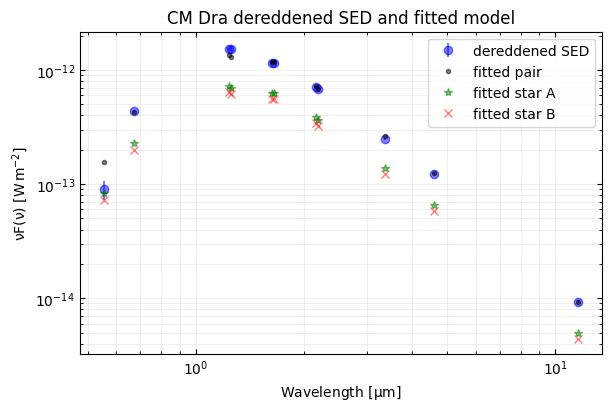

In [16]:
print(f"Best fit parameters for {target} from the 'minimize' fit")
for ix, (l, unit) in enumerate(theta_labels[fit_mask]):
    known_val = ufloat(target_config.get(l, np.NaN), target_config.get(l + "_err", None) or 0)
    print(f"{l:>12s} = {theta_for_p0[fit_mask][ix]:.3f} {unit:unicode} (known value {known_val:.3f})")

plot_fitted_model(sed, theta_for_p0, f"{target_data['label']} dereddened SED and fitted model")

### Perform MCMC fitting for a more reliable fit with uncertainties from a probability distribution

In [17]:
thin_by = 10
theta_fit, sampler = mcmc_fit(x=model_sed.get_filter_indices(sed["sed_filter"]),
                              y=sed["sed_der_flux"].quantity.to(u.Jy).value,
                              y_err=sed["sed_eflux"].quantity.to(u.Jy).value,
                              prior_criteria=prior_criteria,
                              theta0=theta_for_p0,
                              fit_mask=fit_mask,
                              flux_func=model_sed.get_fluxes,
                              nwalkers=100,
                              nsteps=100000,
                              thin_by=thin_by,
                              seed=42,
                              early_stopping=True,
                              processes=8,
                              progress=True,
                              verbose=True)

mcmc_fit(theta0=[3.190e+03*, 3.179e+03*, 2.512e-01*, 2.374e-01*, 4.906e+00, 4.906e+00, 1.486e+01])
Running MCMC fit with 100 walkers for 100000 steps, thinned by 10, on 8 process(es). Early stopping is enabled after 2500 steps.


 10%|█         | 10000/100000 [07:41<1:09:11, 21.68it/s]


Halting MCMC after 10,000 steps as the walkers are past 100 times the autocorrelation time & the fit has converged.
Autocorrelation steps (tau): 46.219, 45.297, 48.152, 47.848
Estimated burn-in steps:     96
Mean Acceptance fraction:    0.591
Nominals of fitted theta:    [3.187e+03*, 3.172e+03*, 2.523e-01*, 2.378e-01*, 4.906e+00, 4.906e+00, 1.486e+01]


In [18]:
accept_frac = np.mean(sampler.acceptance_fraction)
tau = sampler.get_autocorr_time(c=5, tol=50, quiet=True) * thin_by
burn_in_steps = int(max(np.nan_to_num(tau, copy=True, nan=1000)) * 2)
print(f"Estimated burn-in steps:     {burn_in_steps:,}")

Estimated burn-in steps:     96


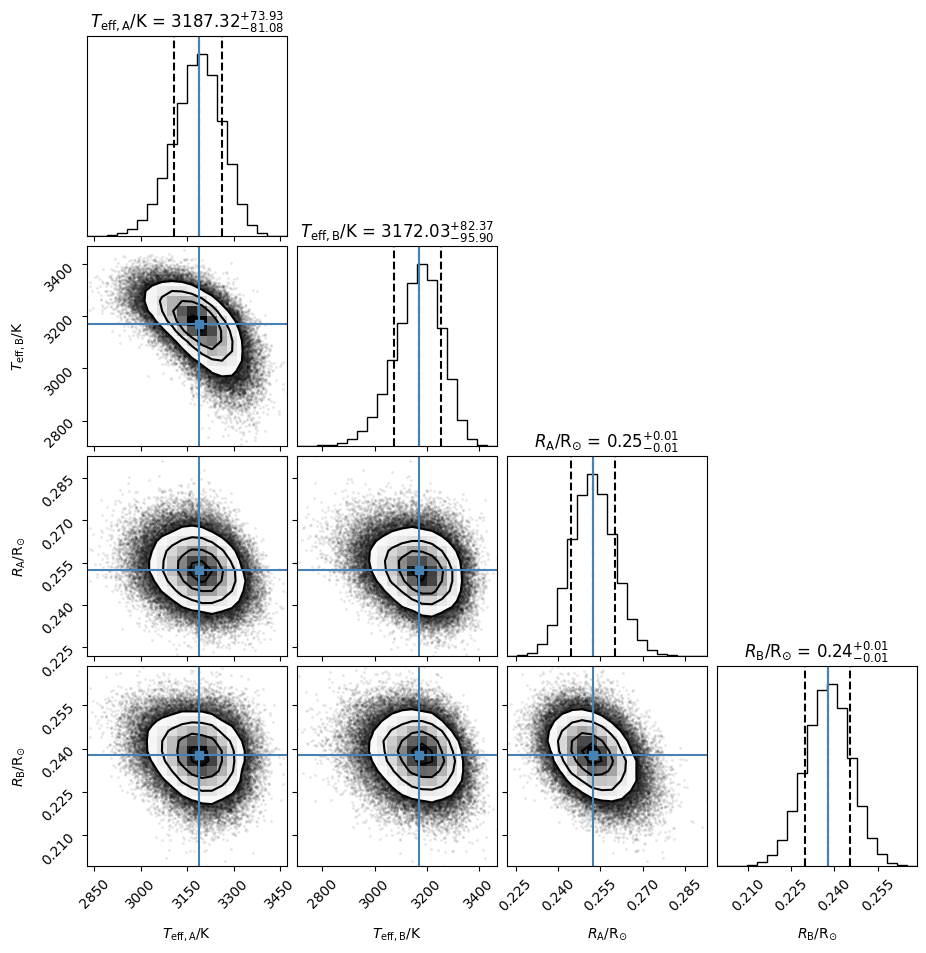

In [19]:
# thin; every nth step from the chain
samples = sampler.get_chain(discard=burn_in_steps, flat=True)
fig = corner.corner(samples, show_titles=True, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84],
                    labels=theta_plot_labels[fit_mask], truths=theta_for_p0[fit_mask])
plt.show(fig)
plt.close(fig)

Best fit parameters for CM Dra from subsequent MCMC fit
       TeffA = 3187.321 +/- 73.963/81.078 K (known value 3130.000+/-70.000 K)
       TeffB = 3172.036 +/- 82.373/95.905 K (known value 3120.000+/-70.000 K)
          RA = 0.252 +/- 0.008/0.008 R☉ (known value 0.253+/-0.002 R☉)
          RB = 0.238 +/- 0.008/0.008 R☉ (known value 0.240+/-0.002 R☉)


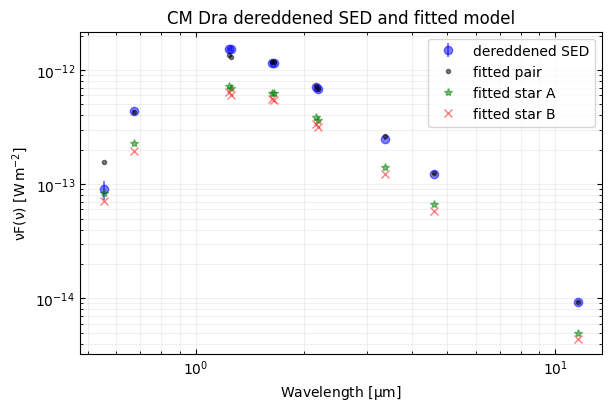

In [20]:
# Gets the median +/- err for fitted values only, not the full theta
fitted_noms = np.median(samples[burn_in_steps:], axis=0)
fitted_err_high = np.quantile(samples[burn_in_steps:], 0.84, axis=0) - fitted_noms
fitted_err_low = fitted_noms - np.quantile(samples[burn_in_steps:], 0.16, axis=0)

print(f"Best fit parameters for {target} from subsequent MCMC fit")
for ix, (l, unit) in enumerate(theta_labels[fit_mask]):
    known_val = ufloat(target_config.get(l, np.NaN), target_config.get(l + "_err", None) or 0)
    print(f"{l:>12s} = {fitted_noms[ix]:.3f}",
          f"+/- {fitted_err_high[ix]:.3f}/{fitted_err_low[ix]:.3f}",
          f"{unit:unicode} (known value {known_val:.3f} {unit:unicode})")

theta_fit[fit_mask] = fitted_noms
plot_fitted_model(sed, theta_fit, f"{target_data['label']} dereddened SED and fitted model")